In [29]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import History

In [31]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [32]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [33]:
from keras.models import Model
from keras.layers import Input

In [42]:
visible = Input(shape=(X_train.shape[1],))
hidden1 = Dense(100, activation='sigmoid')(visible)
hidden2 = Dense(50, activation='sigmoid')(hidden1)
hidden3 = Dense(10, activation='sigmoid')(hidden2)
output = Dense(1, activation='sigmoid')(hidden3)
model = Model(inputs=visible, outputs=output)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 41)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               4200      
_________________________________________________________________
dense_37 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_38 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [43]:
history_sgd = History()
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Train on 30162 samples, validate on 15060 samples
Epoch 1/100
30162/30162 [==============================] - 3s 105us/step - loss: 0.5211 - accuracy: 0.7544 - val_loss: 0.3948 - val_accuracy: 0.8145
Epoch 2/100
30162/30162 [==============================] - 3s 89us/step - loss: 0.3539 - accuracy: 0.8358 - val_loss: 0.3425 - val_accuracy: 0.8365
Epoch 3/100
30162/30162 [==============================] - 3s 95us/step - loss: 0.3373 - accuracy: 0.8412 - val_loss: 0.3339 - val_accuracy: 0.8454
Epoch 4/100
30162/30162 [==============================] - 3s 89us/step - loss: 0.3322 - accuracy: 0.8445 - val_loss: 0.3315 - val_accuracy: 0.8446
Epoch 5/100
30162/30162 [==============================] - 3s 88us/step - loss: 0.3298 - accuracy: 0.8477 - val_loss: 0.3291 - val_accuracy: 0.8477
Epoch 6/100
30162/30162 [==============================] - 3s 93us/step - loss: 0.3287 - accuracy: 0.8459 - val_loss: 0.3284 - val_accuracy: 0.8471
Epoch 7/100
30162/30162 [==============================] - 3s

Epoch 56/100
30162/30162 [==============================] - 3s 89us/step - loss: 0.3048 - accuracy: 0.8576 - val_loss: 0.3205 - val_accuracy: 0.8520
Epoch 57/100
30162/30162 [==============================] - 3s 88us/step - loss: 0.3046 - accuracy: 0.8583 - val_loss: 0.3220 - val_accuracy: 0.8484
Epoch 58/100
30162/30162 [==============================] - 3s 88us/step - loss: 0.3041 - accuracy: 0.8579 - val_loss: 0.3253 - val_accuracy: 0.8508
Epoch 59/100
30162/30162 [==============================] - 3s 91us/step - loss: 0.3038 - accuracy: 0.8572 - val_loss: 0.3209 - val_accuracy: 0.8497
Epoch 60/100
30162/30162 [==============================] - 3s 90us/step - loss: 0.3041 - accuracy: 0.8569 - val_loss: 0.3199 - val_accuracy: 0.8508
Epoch 61/100
30162/30162 [==============================] - 3s 89us/step - loss: 0.3034 - accuracy: 0.8580 - val_loss: 0.3273 - val_accuracy: 0.8434
Epoch 62/100
30162/30162 [==============================] - 3s 90us/step - loss: 0.3033 - accuracy: 0.8584

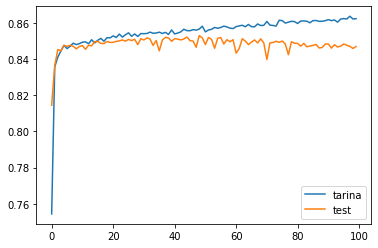

In [45]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad 

Zbuduj i przetestuj sieć przestawioną na rysunku:

<img src="https://adeshpande3.github.io/assets/LeNet.png" width="700">
Źródło: https://adeshpande3.github.io/assets/LeNet.png"